# Code file to evaluate the pre-trained VAE-MLP pipeline
### Katherine Duncker
#### 4/11/2025
#### You Lab

This code can be copied to run any dataset generated in this study also utilizing files loaded in throughout this notebook.

## Import necessary packages and define device for torch

In [1]:
#import python packages
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#import data loading and pre-processing functions from separate .py files
from data_loading_v5 import define_metadata, import_exp_data, filter_dataframes, process_dataframes, convert_reader_data, subtract,normalize 
from plot_timecourses import plottimecourselist, plottimecoursearray, figure_layout 
from crosstalk import crosstalk, mixed_crosstalk, antibiotic_crosstalk
from dose_response_fitting import dose_response_fitting
from mechanistic_model import difeq_newest_test_2, fp_total_timecourse, sensor_fit, plot_fittings
from VAE import VAE, train, test, warmup_scheduler, get_latent_variables, count_parameters
from VAEMLP import MLP, CombinedModel, combo_train, validate

## Select which community to use and process data

In [2]:
#select which microbial community dataset to work with
community='aTc_IPTG' #list of options: 'aTc_IPTG','TTR_THS','cuma_ohc_atc','van_dapg_nar', 'antibiotic_data', 'ttr_ths_ph'

#if using antibiotic data, indicate the plasmid and inhibitor combination
plasmid='BlaM' #options: 'Bla', 'BlaM', 'HSGBla', 'HSGBlaM'
inhibitor='SUL' #options: 'TAZ', 'SUL'
if community!='antibiotic_data':
    plasmid=None
    inhibitor=None

#import metadata for selected community
files,readers, fluors, fluor1, fluor2, fluor3, single_file, sensor_names, sensors,time_vector,od_raws,input_arrays,input_names,fp1_raws,fp2_raws,fp3_raws = define_metadata(community,plasmid,inhibitor)

if community=='antibiotic_data':
    od_conv=od_raws
    fp1_conv=fp1_raws
    fp2_conv=fp2_raws
    fp3_conv=None
else:
    # convert the plate reader data to match based on calibrations
    od_conv=convert_reader_data(readers, None, od_raws,community)
    fp1_conv=convert_reader_data(readers, fluor1, fp1_raws,community)
    fp2_conv=convert_reader_data(readers, fluor2, fp2_raws,community)
    if sensors==3:
        fp3_conv=convert_reader_data(readers, fluor3, fp3_raws,community)
    else:
        fp3_conv=None

# Subtract basal expression (sample with 0 inducers added) time course from all time courses of the same experiment 
subtracted_fp1_conv_all, subtracted_fp2_conv_all, subtracted_fp3_conv_all=subtract(community,time_vector,fp1_conv,fp2_conv,fp3_conv,sensors,input_arrays)

# Min-max scale each fluorescence time course to be on a scale from 0-1
normalized_fp1_conv_all, normalized_fp2_conv_all, normalized_fp3_conv_all=normalize(subtracted_fp1_conv_all,subtracted_fp2_conv_all,subtracted_fp3_conv_all)

#Append the full OD and fluorescence timecourses from the normalized dataset
#stack the OD time courses to be in the same format the fluorescence curves are
od_stack=np.empty((0,len(time_vector)), dtype=float)
for i, reader in enumerate(fluor1):
    od_stack=np.vstack((od_stack,od_conv[i]))
# Initialize the list of arrays to concatenate
concat_list = [od_stack]
#append each time course
concat_list.append(normalized_fp1_conv_all)
concat_list.append(normalized_fp2_conv_all)
if normalized_fp3_conv_all is not None and normalized_fp3_conv_all.size>0:  # Check if fp3 is None
    concat_list.append(normalized_fp3_conv_all)
exp_data_new=np.concatenate(concat_list,axis=1)
    
#concatenate all experimental input data into one array
exp_inputs=np.vstack(list(input_arrays.values())) #used to be normalized_input_arrays

### Load parameters and process inputs

In [3]:
'''load the calculated sensor parameter values if not calculating them this time'''#choose timepoint calculation for alpha you want to import
timepoint=20 
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"parameter_files/{community}/"

alpha_files=glob.glob(f'{save_dir}*_{timepoint}hr_{community}_alphas_mixed.npy') # List all matching files
alphas=np.load(max(alpha_files)) #load the most recent K calc file

#choose timept calculation for hill parameters you want to import
hill_timepoint=20 

K_files=glob.glob(f'{save_dir}*_{hill_timepoint}hr_{community}_K_calc.npy') # List all matching files
K_calc=np.load(max(K_files)) #load the most recent K calc file
    
hill_files=glob.glob(f'{save_dir}*_{hill_timepoint}hr_{community}_hill_coef.npy') # List all matching files
hill_calc=np.load(max(hill_files)) #load the most recent hill calc file


'''normalize inputs and K_calc with K_calc (everything will be centered around 1 and K will be 1 for each sensor)'''

'''calculate the limit range for inputs based on K and n'''
# extract true_K = K_calc for the respective intended sensor
true_K=np.zeros(sensors) #true_K= K values in same order as input 1, input 2
upper=np.zeros(sensors)
lower=np.zeros(sensors)
for i in range(sensors):
    true_K[i]=K_calc[i*sensors + i] 
    upper[i]=true_K[i]*(99**(1/hill_calc[i*sensors + i]))
    lower[i]=true_K[i]/(99**(1/hill_calc[i*sensors + i])) 

'''Remove data where inputs are outside threshold limits''' #cut this section if it doesn't help the prediction
if ((community=='cuma_ohc_atc')|(community=='van_dapg_nar')|(community=='antibiotic_data')):
    mask=(exp_inputs>0).all(axis=1)
else:
    mask = (exp_inputs >= lower).all(axis=1) & (exp_inputs <= upper).all(axis=1) 
# Filter the arrays based on the mask
filtered_exp_inputs = exp_inputs[mask]
filtered_exp_data_new = exp_data_new[mask]

'''normalize inputs and K_calc with the K value for the intended sensor'''
# Normalize the filtered inputs array by dividing by K
normalized_exp_inputs = filtered_exp_inputs / true_K  #fgh - change filtered_exp_inputs to exp_inputs if we don't want to cut that many datapoints
normalized_K_calc=K_calc.reshape((sensors,sensors))/true_K #reshaped to make the calculation easier and needs to be reshaped for the ODEs anyway

## Run the simulated and experimental data through the VAE-MLP pipeline

We'll build a VAE+MLP to do input concentration estimation.
We first train a VAE using simulated data only (this will be modified later to be trained on all data) to recostruct the timecourses.
Then we using the trained VAE to train a combo VAE-MLP (where only the MLP model is updating in the training) to predict the input concentrations from timecourses.

For each iteration right now we are only using one simulated parameter set at a time from data_concat (0,1,2,3) which correspond to two experiments 0&1 correspond to march experiments and 2&3 correspond to June experiments.

Data preparation and sanity check.
1. Load simulated data
2. Each sample (corresponding to one input combination) consists of time courses under 4 parameter combinations.
3. Concatenate the time series of the measurements in each sample to generate a single time series.
4. Generate 10 plot, each showing one time series (concatenated od, fp1, fp2)

In [4]:
'''Load simulated outputs and inputs defined above'''
# Load simulated data
curves_files=glob.glob(f'{save_dir}*_{community}_curves10k.npz') # List all matching files
#load the most recent timecourses file
data_array=np.load(max(curves_files))['arr_0'] #the 'arr_0' retrieves the array information by choosing the default array name #load the most recent params file

S_files=glob.glob(f'{save_dir}*_{community}_S_10k.npy') # List all matching files
inputs=np.load(max(S_files)) #load the most recent inputs file

#append the timecourses for each sample together to go from (10000,3, time) to (10000, 3*time) - flatten the array to be 2D
data_concat = data_array.reshape(data_array.shape[0], -1)

# prepare the data(time series).
#data_np = data_concat[:,0,:] #numpy array of the simulated datset
seq_length = data_concat.shape[1]

#combine experimental and simulated data
combined_data_np=np.vstack((data_concat,filtered_exp_data_new)) #numpy array of combined dataset

#create indices to locate the experimental data
exp_data_indices = range(data_concat.shape[0], data_concat.shape[0] + filtered_exp_data_new.shape[0])

#normalize full data
scaler = MinMaxScaler()
data_normalized_np = scaler.fit_transform(combined_data_np)
# Convert data into tensor
data_normalized = torch.tensor(data_normalized_np).float()
 # Add an extra dimension for the 1D CNN (batch_size, num_channels, seq_length)
data_normalized = data_normalized.unsqueeze(1)

#prepare experimental data for testing
#scale exp_data
exp_data_normalized = scaler.transform(filtered_exp_data_new)
# Convert data into tensor
exp_data_normalized = torch.tensor(exp_data_normalized).float()
 # Add an extra dimension for the 1D CNN (batch_size, num_channels, seq_length)
exp_data_normalized = exp_data_normalized.unsqueeze(1)

import time as timer
# Determine device (enables GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
'''load the pre-trained VAE model and train/test split indices and define hyperparameters'''
# Hyperparameters
batch_size = 32
latent_dim = 10
latent_channel=6
alpha = 1e-4 #coefficient in the trianing which balances the importance of reconstruction loss and KL divergence (5e-4 for old bla model)
lr= 1e-3 #learning rate for the optimizer (1e-3 for combo model)
min_lr = 5e-6 #(1e-7 for Lingchong's model)
epochs = 400 #(1000 for Lingchong's model)
gamma = 0.99 #(0.98 for Lingchong's model)
weight_decay=1e-5

# Model creation, loss function, and optimizer
# torch.manual_seed(42)
model = VAE(latent_dim=latent_dim,latent_channel=latent_channel,seq_length=seq_length)
model = model.to(device)

#define file path
if community=='antibiotic_data':
    save_dir = f"final_trained_models/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"final_trained_models/{community}/"

#load the pre-trained VAE model
VAE_model_files=glob.glob(f'{save_dir}*_VAE_{community}.pt') #list all matching files
#load the most recent train indices file
model.load_state_dict(torch.load(max(VAE_model_files)))

# load training and testing indices
train_ind_files=glob.glob(f'{save_dir}*_train_indices_{community}.npy') #list all matching train indices files
#load the most recent train indices file
train_indices=np.load(max(train_ind_files))
test_ind_files=glob.glob(f'{save_dir}*_test_indices_{community}.npy') #list all matching train indices files
#load the most recent test indices file
test_indices=np.load(max(test_ind_files))

# DataLoader
train_data = data_normalized[train_indices].clone().detach().float()
# train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = data_normalized[test_indices].clone().detach().float()
# test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

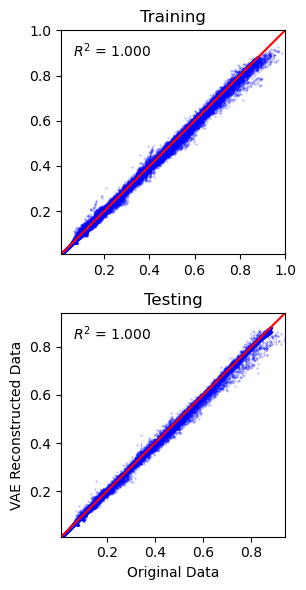

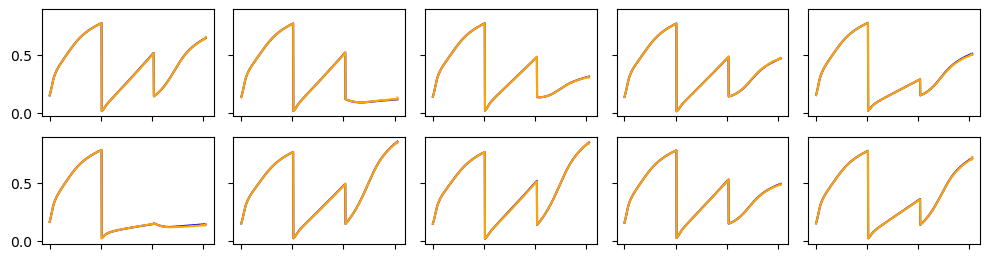

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#save figure
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"
os.makedirs(save_dir, exist_ok=True)


# Percentage of data to retrieve
percentage = 1

# Calculate the number of samples to retrieve
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples].to(device)
subset_test_data = test_data[:num_test_samples].to(device)

#evaluate model 
model.eval()
with torch.no_grad():
    output_train, _, _ = model(subset_train_data,latent_channel,seq_length,use_mean=True)
    output_test, _, _ = model(subset_test_data,latent_channel,seq_length,use_mean=True)


# Squeeze the output to match the original data dimension
output_train = output_train.squeeze(1)
output_test = output_test.squeeze(1)

##fix min-max
# Scale the reconstructed data back to the range of the original data
output_train = scaler.inverse_transform(output_train.cpu().numpy())
output_test = scaler.inverse_transform(output_test.cpu().numpy())
# Scale the original data back to the original range
subset_train_data = scaler.inverse_transform(subset_train_data.cpu().numpy().squeeze(1))
subset_test_data = scaler.inverse_transform(subset_test_data.cpu().numpy().squeeze(1))

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(2, 1, figsize=(3, 6))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), output_train.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([np.min(subset_train_data), np.max(subset_train_data)], [np.min(subset_train_data), np.max(subset_train_data)], 'r')  # y=x line
axs[0].set_xlim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_ylim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_aspect('equal', adjustable='box')
# axs[0].set_xlabel('Original Data')
# axs[0].set_ylabel('Reconstructed Data')
axs[0].set_title('Training')
r2_train = r2_score(subset_train_data.flatten(), output_train.flatten())
axs[0].text(0.05, 0.95,fr'$R^2$ = {r2_train:.3f}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), output_test.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([np.min(subset_test_data), np.max(subset_test_data)], [np.min(subset_test_data), np.max(subset_test_data)], 'r')  # y=x line
axs[1].set_xlim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_ylim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original Data')
axs[1].set_ylabel('VAE Reconstructed Data')
axs[1].set_title('Testing')
r2_test = r2_score(subset_test_data.flatten(), output_test.flatten())
axs[1].text(0.05, 0.95,fr'$R^2$ = {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
#save figure if you want: has to be png for this figure because there are too many points to render a svg
fig.savefig(f'{save_dir}VAE_augmented_r2.png',format='png',dpi=300)

plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(2, 5, figsize=(10, 2.7),sharey=True,sharex=True)

# Training data trajectories
for i in range(5):
    axs[0, i].plot(subset_train_data[i], label='Original', color='blue')
    axs[0, i].plot(output_train[i], label='Reconstructed', color='orange')
    # axs[0, i].set_title(f'Training {i + 1}')
#    axs[0, i].legend()

# Testing data trajectories
for i in range(5):
    axs[1, i].plot(subset_test_data[i], label='Original', color='blue')
    axs[1, i].plot(output_test[i], label='Reconstructed', color='orange')
    # axs[1, i].set_title(f'Testing {i + 1}')
#    axs[1, i].legend()

for r in range(2):  # rows
    for c in range(5):  # columns
        if not (c == 0):  # keep only bottom-leftmost tick labels
            axs[r, c].tick_params(labelleft=False)
        # hide all x-axis tick labels
        axs[r, c].tick_params(labelbottom=False)
        

plt.tight_layout()
#save figure if you want
fig.savefig(f'{save_dir}VAE_augmented_reconstructions.svg',format='svg')
plt.show()


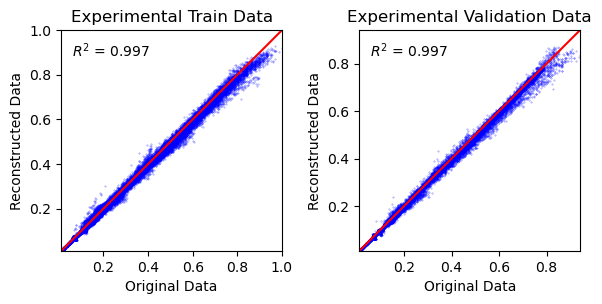

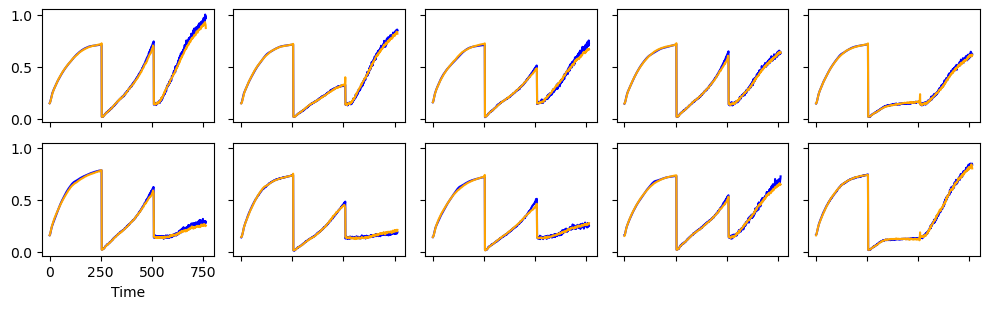

In [33]:
#plot the experimental reconstruction with the VAE of the full timecourses

# Create masks for identifying indices belonging to filtered_exp_data_new
train_mask = np.isin(train_indices, exp_data_indices)
test_mask = np.isin(test_indices, exp_data_indices)

# Extract the relevant parts using the masks
train_filtered_data = train_data[train_mask]
test_filtered_data = test_data[test_mask]

#evaluate model 
model.eval()
with torch.no_grad():
    output_train, _, _ = model(train_filtered_data.to(device),latent_channel,seq_length,use_mean=True) #set use_mean to False or delete it (default is False) if you want stochastic results, reparameterizes every time. set use_mean=True if you want deterministic results.
    output_test, _, _ = model(test_filtered_data.to(device),latent_channel,seq_length,use_mean=True) #set use_mean to False or delete it (default is False) if you want stochastic results, reparameterizes every time. set use_mean=True if you want deterministic results.

# Squeeze the output to match the original data dimension
output_train = output_train.squeeze(1)
output_test = output_test.squeeze(1)

# Scale the reconstructed data back to the range of the original data
#output_train = output_train.cpu().numpy()

# Scale the reconstructed data back to the range of the original data
output_train = scaler.inverse_transform(output_train.cpu().numpy())
output_test = scaler.inverse_transform(output_test.cpu().numpy())
# Scale the original data back to the original range
subset_train_data = scaler.inverse_transform(train_filtered_data.cpu().numpy().squeeze(1)) 
subset_test_data = scaler.inverse_transform(test_filtered_data.cpu().numpy().squeeze(1)) 

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), output_train.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([np.min(subset_train_data), np.max(subset_train_data)], [np.min(subset_train_data), np.max(subset_train_data)], 'r')  # y=x line
axs[0].set_xlim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_ylim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original Data')
axs[0].set_ylabel('Reconstructed Data')
axs[0].set_title('Experimental Train Data')
r2_train = r2_score(subset_train_data.flatten(), output_train.flatten())
axs[0].text(0.05, 0.95, fr'$R^2$ = {r2_test:.3f}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), output_test.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([np.min(subset_test_data), np.max(subset_test_data)], [np.min(subset_test_data), np.max(subset_test_data)], 'r')  # y=x line
axs[1].set_xlim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_ylim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original Data')
axs[1].set_ylabel('Reconstructed Data')
axs[1].set_title('Experimental Validation Data')
r2_test = r2_score(subset_test_data.flatten(), output_test.flatten())
axs[1].text(0.05, 0.95, fr'$R^2$ = {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
#save figure if you want
fig.savefig(f'{save_dir}VAE_experimental_r2.png',format='png',dpi=300)

plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(2, 5, figsize=(10, 3.2),sharey=True,sharex=True)

# Training data trajectories
for i in range(5):
    axs[0, i].plot(subset_train_data[i], label='Original', color='blue')
    axs[0, i].plot(output_train[i], label='Reconstructed', color='orange')
    # axs[0, i].set_title(f'Exp train{i + 1}')
#    axs[0, i].legend()

# Testing data trajectories
for jj in range(5):
    i=jj+5
    axs[1, jj].plot(subset_test_data[i], label='Original', color='blue')
    axs[1, jj].plot(output_test[i], label='Reconstructed', color='orange')
    # axs[1, jj].set_title(f'Exp test{i + 1}')
#    axs[1, i].legend()

for r in range(2):  # rows
    for c in range(5):  # columns
        if not (r == 1 and c == 0):  # keep only bottom-leftmost tick labels
            axs[r, c].tick_params(labelbottom=False)
        if not (c == 0):  # keep only bottom-leftmost tick labels
            axs[r, c].tick_params(labelleft=False)


axs[1,0].set_xlabel('Time')

plt.tight_layout()
#save figure if you want
# 
fig.savefig(f'{save_dir}VAE_experimental_reconstructions.svg',format='svg')
plt.show()


## Combined VAE-MLP code
### training/testing the MLP part on simulated data
The following code:
1. Load a pre-trained VAE model with latent dimension of 10. It is important to make sure the architecture of the pre-trained VAE is identical to what's defined in this code.
2. Create a new model by combining the encoder of the VAE model and an MLP model to map the latent variables to parameters.
3. Train the combined model by using the time courses of n to predict the corresponding parameter values.
4. During the training, the pre-trained model encoder is frozen. That is, the NN parameters associated with the encoder are not further adjusted. Instead, only the MLP parameters are updated.
5. Upon training, the combined model can then allow the estimation of ODE parameters from the n time courses.

During training, learn rate decays exponentially by a rate of 'gamma'. The training also implements weight decay to penalize large weights.
In addition, the training is stopped if test loss does not decrease in 30 consecutive epochs

In [5]:
'''Process data for combining both simulated and experimental data prior to training MLP'''
#combine experimental and simulated input data
combined_inputs=np.vstack((inputs,normalized_exp_inputs))

#log transform combined dataset
log_inputs=np.log10(combined_inputs)
#convert inputs to tensor
log_inputs=torch.from_numpy(log_inputs).float().to(device) #used as the input into the model to train on

#prepare experimental data for testing
#log transform experimental data
log_exp_inputs=np.log10(normalized_exp_inputs) #natural log
# Convert inputs to torch tensor
exp_inputs_tensor = torch.from_numpy(log_exp_inputs).float().to(device)

'''create variables and hyperparameters for VAE-MLP'''
#MLP input and output size
input_size = data_normalized.shape[1] 
output_size = log_inputs.shape[1]

# VAE Hyperparameters - redefine for combo model - make sure they are the same as those used to train the VAE model being used
batch_size = 32
latent_dim = 10      #call latent dimension size for VAE 
latent_channel=6     #call latent channel size for vae
lr= 1e-3 #learning rate for the optimizer (1e-3 for combo model)
min_lr = 5e-6 
epochs = 400 
gamma = 0.99 
weight_decay=1e-5

#MLP hyperparameter
hidden_size = 128    #width of MLP hidden layers


In [10]:
'''
Load the previously trained VAE-MLP model
'''
# load training and testing indices
if community=='antibiotic_data':
    save_dir = f"final_trained_models/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"final_trained_models/{community}/"
train_ind_files=glob.glob(f'{save_dir}*_train_indices_{community}.npy') #list all matching train indices files
#load the most recent train indices file
train_indices=np.load(max(train_ind_files))
test_ind_files=glob.glob(f'{save_dir}*_test_indices_{community}.npy') #list all matching train indices files
#load the most recent test indices file
test_indices=np.load(max(test_ind_files))

# generate train and test dataset
X_train=data_normalized[train_indices]
X_test = data_normalized[test_indices]
y_train = log_inputs[train_indices]
y_test = log_inputs[test_indices]

# convert to tensors
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Create an instance of the MLP model
mlp_model = MLP(latent_dim, hidden_size, output_size).to(device)
# Create an instance of the VAE model
vae_model = VAE(latent_dim,latent_channel,seq_length).to(device)
# Create an instance of the combined model
combined_model_combo2 = CombinedModel(vae_model, mlp_model).to(device)

#load the trained VAE-MLP model
VAEMLP_files=glob.glob(f'{save_dir}*_VAEMLP_{community}.pt') #list all matching VAE_MLP files
#load the most recent VAE-MLP model file
combined_model_combo2.load_state_dict(torch.load(max(VAEMLP_files)))


#print number of parameters for the combined VAE-MLP model
print(f'The mlp model has {count_parameters(mlp_model):,} parameters')
print(f'The combined model has {count_parameters(combined_model_combo2):,} parameters')

The mlp model has 18,178 parameters
The combined model has 177,775 parameters


1. Plot training and testing losses as the function of epochs
2. Plot the reconstructed input concentrations against the true input concentrations for each input individually. Show R^2 scores.
3. The 2 inputs are:
input_names 

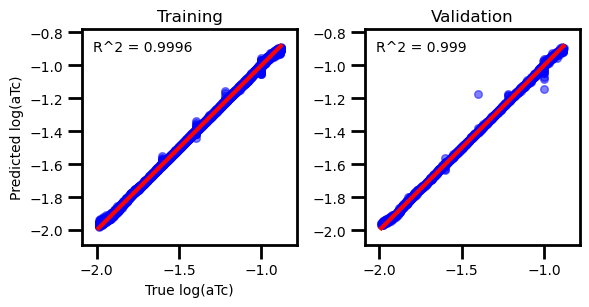

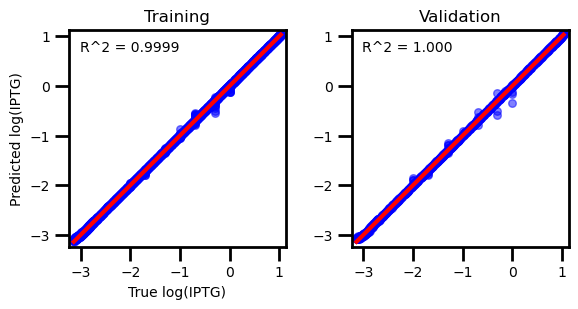

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"
os.makedirs(save_dir, exist_ok=True)


# Percentage of data to retrieve
# For this data size, looking at all data is exhausting the memory of the cluster node.
#
percentage = 1

# Calculate the number of samples to retrieve
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Get the tensor data without labels
subset_train_input = train_data[:num_train_samples][0]
subset_test_input = test_data[:num_test_samples][0]

with torch.no_grad():
    output_train = combined_model_combo2(subset_train_input.to(device),latent_channel,seq_length)
    output_test = combined_model_combo2(subset_test_input.to(device),latent_channel,seq_length)


# Squeeze the output to match the original data dimension
output_train = output_train.squeeze(1)
output_test = output_test.squeeze(1)

# Scale the reconstructed data back to the range of the original data
subset_train_data = (np.log10(true_K*10**(train_data[:num_train_samples][1].cpu().numpy())))#denormalize_parameters(train_data[:num_train_samples][1].cpu().numpy(), input_scale)
subset_test_data = (np.log10(true_K*10**(test_data[:num_test_samples][1].cpu().numpy()))) #denormalize_parameters(test_data[:num_test_samples][1].cpu().numpy(), input_scale)
output_train = (np.log10(true_K*10**(output_train.cpu().numpy())))#denormalize_parameters(output_train.cpu().numpy(), input_scale)
output_test = (np.log10(true_K*10**(output_test.cpu().numpy())))#denormalize_parameters(output_test.cpu().numpy(), input_scale)

# Custom function to round to the nearest 0.5
def round_to_nearest_half(value):
    return round(value * 2) / 2

# Loop over the columns
for col in range(output_train.shape[1]):
    # Create a new figure for each column
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Training data plot
    axs[0].plot([np.min(subset_train_data[:, col]), np.max(subset_train_data[:, col])], [np.min(subset_train_data[:, col]), np.max(subset_train_data[:, col])], color='red',lw=3)  # y=x line
    axs[0].scatter(subset_train_data[:, col], output_train[:, col], s=30, color='blue', alpha=0.5)
    axs[0].set_xlim(np.min(subset_train_data[:, col])-0.1, np.max(subset_train_data[:, col])+0.1)
    axs[0].set_ylim(np.min(subset_train_data[:, col])-0.1, np.max(subset_train_data[:, col])+0.1)
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].set_xlabel(f'True log(' +input_names[col]+')')
    axs[0].set_ylabel(f'Predicted log(' +input_names[col]+')')


    ticks=[round_to_nearest_half(np.min(subset_train_data[:, col])),round_to_nearest_half(np.median(subset_train_data[:, col])),round_to_nearest_half(np.max(subset_train_data[:, col]))]
    #axs[0].set_xticks(ticks)
    #axs[0].set_xticklabels([])
    #axs[0].set_yticks(ticks)
    #axs[0].set_yticklabels([])
    axs[0].set_title('Training')
    axs[0].tick_params(axis='both', length=10, width=2)  # Increase length and width of ticks
    r2_train = r2_score(subset_train_data[:, col], output_train[:, col])
    axs[0].text(0.05, 0.95, f'R^2 = {r2_train:.4f}', transform=axs[0].transAxes, verticalalignment='top')
    # Make borders thicker
    for spine in axs[0].spines.values():
        spine.set_linewidth(2)  # Set the border thickness

    # Testing data plot
    axs[1].plot([np.min(subset_test_data[:, col]), np.max(subset_test_data[:, col])], [np.min(subset_test_data[:, col]), np.max(subset_test_data[:, col])], color='red',lw=3)  # y=x line
    axs[1].scatter(subset_test_data[:, col], output_test[:, col], s=30, color='blue', alpha=0.5)
    #axs[1].set_xticks(ticks)
    #axs[1].set_xticklabels([])
    #axs[1].set_yticks(ticks)
    #axs[1].set_yticklabels([])
    axs[1].tick_params(axis='both', length=10, width=2)  # Increase length and width of ticks
    axs[1].set_xlim(np.min(subset_test_data[:, col])-0.1, np.max(subset_test_data[:, col])+0.1)
    axs[1].set_ylim(np.min(subset_test_data[:, col])-0.1, np.max(subset_test_data[:, col])+0.1)
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].set_title('Validation')
    r2_test = r2_score(subset_test_data[:, col], output_test[:, col])
    axs[1].text(0.05, 0.95, f'R^2 = {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')
    # Make borders thicker
    for spine in axs[1].spines.values():
        spine.set_linewidth(2)  # Set the border thickness

    plt.tight_layout()
    # uncomment if you want to resave the figures
    # fig.savefig(f'{save_dir}MLP_augmented_{input_names[col]}.svg',format='svg')
    plt.show()


In [14]:
# Create masks for identifying indices belonging to experimental data
train_mask = np.isin(train_indices, exp_data_indices)
test_mask = np.isin(test_indices, exp_data_indices)


mlp_train_exp_curves=X_train[train_mask]
mlp_test_exp_curves=X_test[test_mask]
train_exp_inputs=y_train[train_mask]
test_exp_inputs=y_test[test_mask]

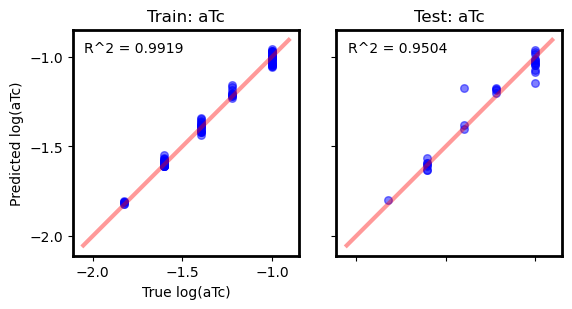

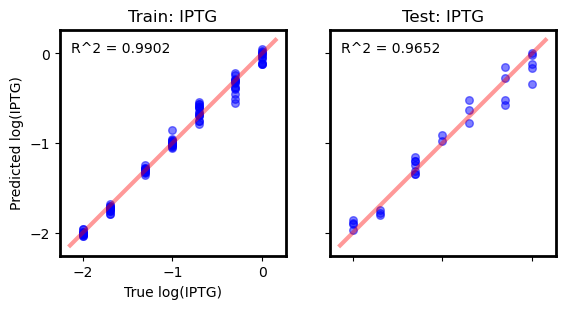

In [15]:
'''Plot experimental data on pre-trained vae-mlp'''
def round_to_nearest_half(value):
    return round(value * 2) / 2
    
with torch.no_grad():
    output_exp_train = combined_model_combo2(mlp_train_exp_curves.to(device),latent_channel,seq_length)
    output_exp_test = combined_model_combo2(mlp_test_exp_curves.to(device),latent_channel,seq_length)

# Squeeze the output to match the original data dimension
output_exp_train = output_exp_train.squeeze(1)
output_exp_test = output_exp_test.squeeze(1)

# Scale the reconstructed data back to the range of the original data
subset_train_data = (np.log10(true_K*10**(train_exp_inputs.cpu().numpy())))#denormalize_parameters(train_data[:num_train_samples][1].cpu().numpy(), input_scale)
subset_test_data = (np.log10(true_K*10**(test_exp_inputs.cpu().numpy()))) #denormalize_parameters(test_data[:num_test_samples][1].cpu().numpy(), input_scale)
output_train = (np.log10(true_K*10**(output_exp_train.cpu().numpy())))#denormalize_parameters(output_train.cpu().numpy(), input_scale)
output_test = (np.log10(true_K*10**(output_exp_test.cpu().numpy())))#denormalize_parameters(output_test.cpu().numpy(), input_scale)

# Loop over the columns
for col in range(output_train.shape[1]):
    # Calculate the min and max values
    min_val = np.min([np.min(subset_train_data[:, col]),np.min(subset_test_data[:, col]),np.min(output_train[:, col]),np.min(output_test[:, col])])
    max_val = np.max([np.max(subset_train_data[:, col]),np.max(subset_test_data[:, col]),np.max(output_train[:, col]),np.max(output_test[:, col])])
    ticks=[round_to_nearest_half(min_val),round_to_nearest_half((min_val + max_val) / 2),round_to_nearest_half(max_val)]
    min_val_w_ticks=np.min([min_val,np.min(ticks)])
    max_val_w_ticks=np.max([max_val,np.max(ticks)])
    # Calculate the range
    data_range = max_val_w_ticks - min_val_w_ticks
    # Add 5% padding to the min and max values
    padding = 0.05 * data_range
    new_min = min_val_w_ticks - padding
    new_max = max_val_w_ticks + padding
    
    # Create a new figure for each column
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    # Training data plot
    axs[0].plot([new_min, new_max], [new_min, new_max], color='red',lw=3, alpha=0.4)  # y=x line
    axs[0].scatter(subset_train_data[:, col], output_train[:, col], s=30, color='blue', alpha=0.5)
    # axs[0].set_xlim(new_min,new_max)
    # axs[0].set_ylim(new_min,new_max)
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].set_title(f'Train: '+ input_names[col])
    axs[0].set_xticks(ticks)
    #axs[0].set_xticklabels([])
    axs[0].set_yticks(ticks)
    #axs[0].set_yticklabels([])
    #axs[0].tick_params(axis='both', length=10, width=2)  # Increase length and width of ticks
    r2_train = r2_score(subset_train_data[:, col], output_train[:, col])
    axs[0].text(0.05, 0.95, f'R^2 = {r2_train:.4f}', transform=axs[0].transAxes, verticalalignment='top')
    axs[0].set_xlabel(f'True log(' +input_names[col]+')')
    axs[0].set_ylabel(f'Predicted log(' +input_names[col]+')')
    
    # Make borders thicker
    for spine in axs[0].spines.values():
        spine.set_linewidth(2)  # Set the border thickness
    
    # Testing data plot
    axs[1].plot([new_min, new_max], [new_min, new_max], color='red',lw=3, alpha=0.4)  # y=x line
    axs[1].scatter(subset_test_data[:, col], output_test[:, col], s=30, color='blue', alpha=0.5)
    # axs[1].set_xlim(new_min,new_max)
    # axs[1].set_ylim(new_min,new_max)
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].set_title(f'Test: '+ input_names[col])
    axs[1].set_xticks(ticks)
    axs[1].set_xticklabels([])
    axs[1].set_yticks(ticks)
    axs[1].set_yticklabels([])
    #axs[1].tick_params(axis='both', length=10, width=2)  # Increase length and width of ticks
    r2_test = r2_score(subset_test_data[:, col], output_test[:, col])
    axs[1].text(0.05, 0.95, f'R^2 = {r2_test:.4f}', transform=axs[1].transAxes, verticalalignment='top')
    # Make borders thicker
    for spine in axs[1].spines.values():
        spine.set_linewidth(2)  # Set the border thickness

    plt.tight_layout()
    # uncomment if you want to resave the figures
    # fig.savefig(f'{save_dir}MLP_experimental_{input_names[col]}.svg',format='svg')
    plt.show()